# Smart Classroom Data Evaluation

## Informationen zur Analyse

### Klassenzimmer "Primarklasse_OG1" / Schulklasse 4a

--- Markdown ---

Stundenplan: <br/><br/>
<img src='Studenplan 4a Oben.png' width=500px height=auto>

### Klassenzimmer "Primarklasse_EG" / Schulklasse 5a

--- Markdown ---

Stundenplan: <br/><br/>
<img src='Stundenplan 5a.png' width=500px height=auto>

### Klassenzimmer "oberstufe" / Verschiedene Klassen

--- Markdown ---

Stundenplan: <br/> <br/>
<img src='Oberstufe.png' width=500px height=auto>

## Setup

### Imports

In [3]:
import psycopg2
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Settings

In [4]:
plt.rcParams['timezone'] = "CET"

### Setup connection

In [5]:
def read_config(filename = 'config.ini'):
    config = configparser.ConfigParser()
    config.read(filename)

    db_hostname = config['DATABASE']['HOSTNAME']
    db_database = config['DATABASE']['DATABASE']
    db_username = config['DATABASE']['USERNAME']
    db_password = config['DATABASE']['PASSWORD']

    return db_hostname, db_database, db_username, db_password

In [6]:
def get_connection():
    db_hostname, db_database, db_username, db_password = read_config()
    return  psycopg2.connect(
        host     = db_hostname,
        database = db_database,
        user     = db_username,
        password = db_password)

### Define function for querying measurements

In [7]:
# get all Classrooms from database and filter them
def get_measurement(name, startDate, endDate):
    con = get_connection()

    sql_stations = f"""
        set timezone = 'CET'; 
        select * from api_classroom
        inner join api_measurementstation on api_classroom.id = api_measurementstation.fk_classroom_id
        inner join api_measurement on api_measurementstation.id = api_measurement.fk_measurement_station_id
        where api_classroom.name = '{name}' and time BETWEEN '{startDate}' AND '{endDate}';
    """    
    result = pd.read_sql_query(sql_stations, con)
    
    result["time"]        = result["time"].dt.tz_convert("CET")
    result["updated_on"]  = result["updated_on"].dt.tz_convert("CET")
    result["insert_time"] = result["insert_time"].dt.tz_convert("CET")
    
    con.close()
    return result

In [146]:
def get_entrance(name, startDate, endDate):
    con = get_connection()

    sql_stations = f"""
        set timezone = 'CET'; 
        select * from api_classroom
        inner join api_measurementstation on api_classroom.id = api_measurementstation.fk_classroom_id
        inner join api_entranceevent on api_measurementstation.id = api_entranceevent.fk_measurement_station_id
        where time BETWEEN '{startDate}' AND '{endDate}' and api_classroom.name = '{name}';
    """    
    result = pd.read_sql_query(sql_stations, con)
    
    result["time"]        = result["time"].dt.tz_convert("CET")
    result["updated_on"]  = result["updated_on"].dt.tz_convert("CET")
    result["insert_time"] = result["insert_time"].dt.tz_convert("CET")
    
    con.close()
    
    result = result.sort_values(['time'])

        
    return result

get_entrance('Primarklasse_EG', '2022-05-05', '2022-05-06')

,id,name,description,room_number,updated_on,id,active,name,fk_classroom_id,id,time,change,insert_time,fk_measurement_station_id
0,2,Primarklasse_EG,Primarklasse Erdgeschoss,YVO,2022-05-04 19:33:13.515229+02:00,2,False,Station_Primar_EG,2,31211,2022-05-05 01:41:03.064464+02:00,1,2022-05-05 01:41:03.240695+02:00,2
1,2,Primarklasse_EG,Primarklasse Erdgeschoss,YVO,2022-05-04 19:33:13.515229+02:00,2,False,Station_Primar_EG,2,31210,2022-05-05 01:35:51.479235+02:00,-1,2022-05-05 01:35:51.702496+02:00,2
2,2,Primarklasse_EG,Primarklasse Erdgeschoss,YVO,2022-05-04 19:33:13.515229+02:00,2,False,Station_Primar_EG,2,31206,2022-05-05 01:20:09.227372+02:00,1,2022-05-05 01:20:09.378168+02:00,2
3,2,Primarklasse_EG,Primarklasse Erdgeschoss,YVO,2022-05-04 19:33:13.515229+02:00,2,False,Station_Primar_EG,2,31205,2022-05-05 01:16:06.413359+02:00,-1,2022-05-05 01:16:06.595938+02:00,2
4,2,Primarklasse_EG,Primarklasse Erdgeschoss,YVO,2022-05-04 19:33:13.515229+02:00,2,False,Station_Primar_EG,2,31202,2022-05-05 01:06:59.622184+02:00,1,2022-05-05 01:06:59.762077+02:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,2,Primarklasse_EG,Primarklasse Erdgeschoss,YVO,2022-05-04 19:33:13.515229+02:00,2,False,Station_Primar_EG,2,31227,2022-05-05 02:32:02.721662+02:00,1,2022-05-05 02:32:02.880390+02:00,2
951,2,Primarklasse_EG,Primarklasse Erdgeschoss,YVO,2022-05-04 19:33:13.515229+02:00,2,False,Station_Primar_EG,2,31222,2022-05-05 02:10:47.207166+02:00,1,2022-05-05 02:10:47.392611+02:00,2
952,2,Primarklasse_EG,Primarklasse Erdgeschoss,YVO,2022-05-04 19:33:13.515229+02:00,2,False,Station_Primar_EG,2,31219,2022-05-05 02:07:45.117378+02:00,1,2022-05-05 02:07:45.266215+02:00,2
953,2,Primarklasse_EG,Primarklasse Erdgeschoss,YVO,2022-05-04 19:33:13.515229+02:00,2,False,Station_Primar_EG,2,31217,2022-05-05 02:04:42.760589+02:00,1,2022-05-05 02:04:42.896746+02:00,2


In [195]:
def get_people_count_overtime(entrance_list):
    people_count     = 0
    lst_people_count = []
    lst_time         = []
    array = []
    
    for index, row in entrance_list.iterrows():
        people_count += row['change']
        ttime = row['time']
        lst_people_count.append(people_count)
        lst_time.append(ttime) 
        
        d = dict({'people_count': people_count, 'time': ttime})
        array.append(d)
    df = pd.DataFrame.from_dict(array,orient='columns')
    df = df.sort_values(['time'], ascending=True)
    return df
    

In [197]:

get_people_count_overtime(get_entrance('Primarklasse_EG', startDate = "2022-05-03 05:00:00", endDate = "2022-05-03 17:30:00"))

,people_count,time
690,115,2022-05-03 05:08:54.078973+02:00
689,116,2022-05-03 05:11:56.184589+02:00
688,117,2022-05-03 05:17:07.648980+02:00
687,118,2022-05-03 05:18:27.659087+02:00
686,119,2022-05-03 05:22:04.178163+02:00
...,...,...
4,3,2022-05-03 16:47:36.424572+02:00
3,2,2022-05-03 16:50:38.654680+02:00
2,1,2022-05-03 17:22:04.010515+02:00
1,2,2022-05-03 17:27:04.318103+02:00


## Evaluation

### Forschungsfragen

#### Wie ist der Zusammenhang zwischen Luftqualität und Frequenz bzw. Dauer des Lüftens?

--- Markdown ---

##### Beispiel 1

In [10]:
data = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 09:30:00")

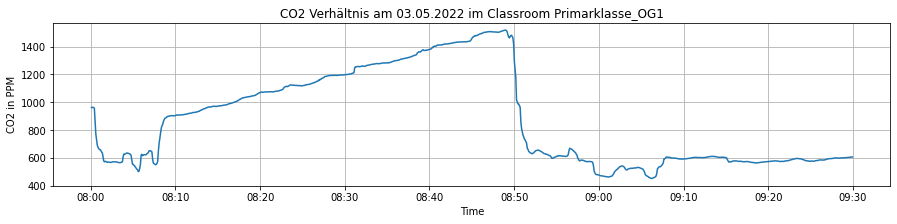

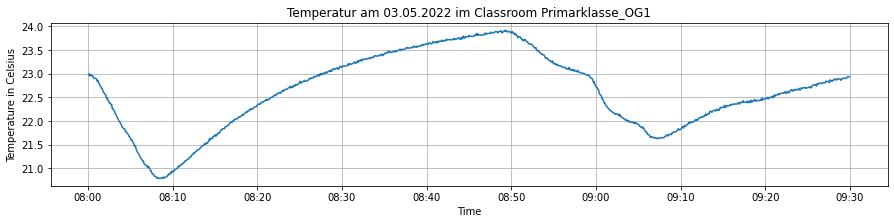

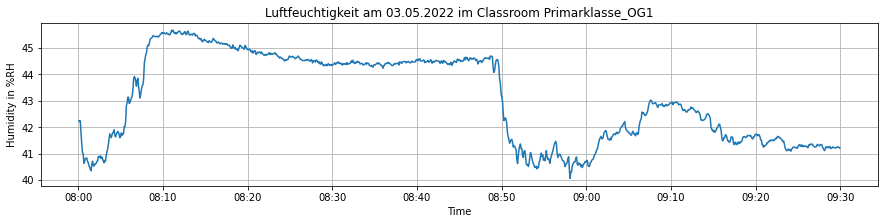

In [11]:
plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom Primarklasse_OG1")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.title("Temperatur am 03.05.2022 im Classroom Primarklasse_OG1")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["humidity"])
plt.xlabel("Time")
plt.ylabel("Humidity in %RH")
plt.title("Luftfeuchtigkeit am 03.05.2022 im Classroom Primarklasse_OG1")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

##### Beispiel 2

In [12]:
data = get_measurement("Primarklasse_EG", startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 09:30:00")

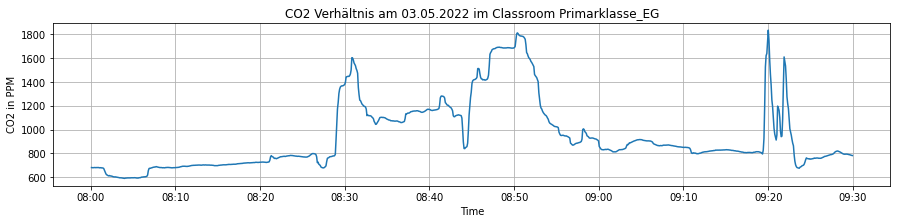

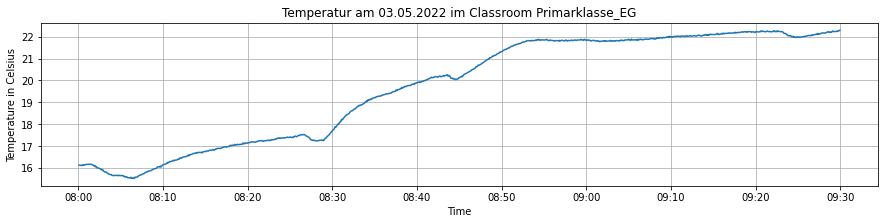

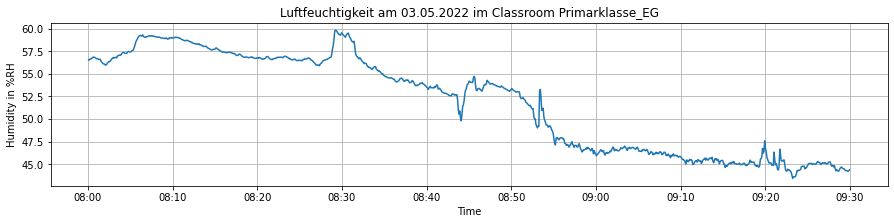

In [13]:
plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom Primarklasse_EG")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.title("Temperatur am 03.05.2022 im Classroom Primarklasse_EG")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["humidity"])
plt.xlabel("Time")
plt.ylabel("Humidity in %RH")
plt.title("Luftfeuchtigkeit am 03.05.2022 im Classroom Primarklasse_EG")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

##### Beispiel 3

In [14]:
data = get_measurement("oberstufe", startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 09:30:00")

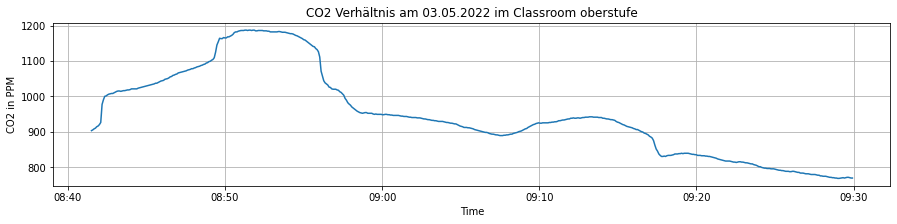

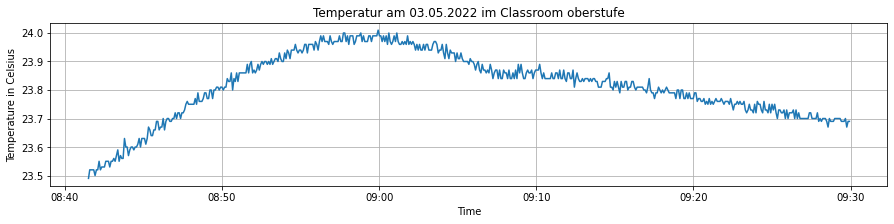

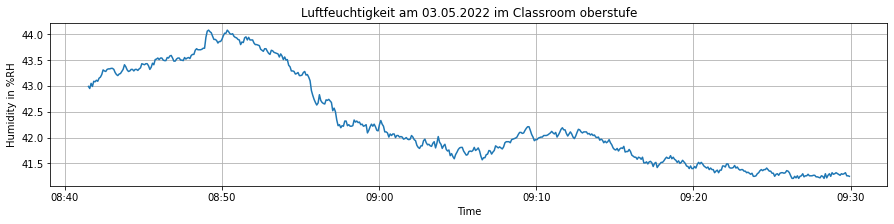

In [15]:
plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.title("Temperatur am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["humidity"])
plt.xlabel("Time")
plt.ylabel("Humidity in %RH")
plt.title("Luftfeuchtigkeit am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

#### Lässt sich anhand der Luftqualität etwas über die Anzahl Personen im Raum aussagen?

--- Markdown ---
#### Oberstufe Zeit / Personen im Raum

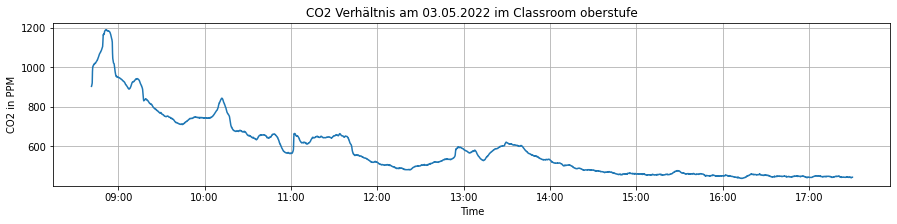

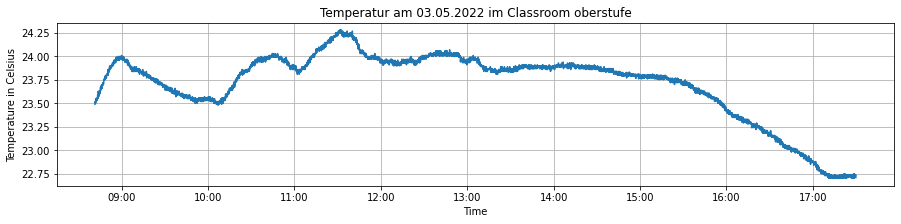

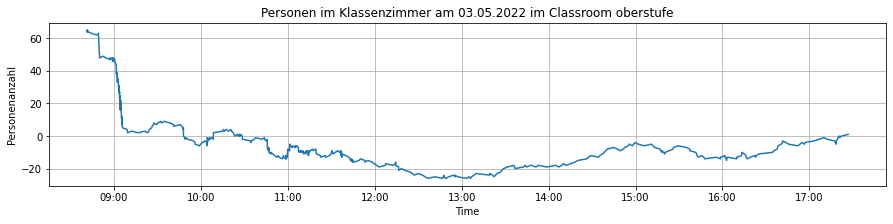

,id,id,fk_classroom_id,id,co2,temperature,humidity,fk_measurement_station_id,light
count,6217.0,6217.0,6217.0,6.217000e+03,6216.000000,6216.000000,6216.000000,6217.0,6215.000000
mean,54.0,5.0,54.0,1.017771e+06,582.398488,23.711459,40.464080,5.0,39929.744167
std,0.0,0.0,0.0,5.382588e+03,154.462190,0.361792,2.693799,0.0,5131.222958
min,54.0,5.0,54.0,1.008450e+06,438.000000,22.700000,34.580000,5.0,17632.000000
25%,54.0,5.0,54.0,1.013115e+06,460.000000,23.570000,39.270000,5.0,41376.000000
50%,54.0,5.0,54.0,1.017770e+06,532.000000,23.840000,40.740000,5.0,41424.000000
75%,54.0,5.0,54.0,1.022432e+06,650.000000,23.940000,41.630000,5.0,41456.000000
max,54.0,5.0,54.0,1.027093e+06,1187.000000,24.280000,47.610000,5.0,41600.000000


In [140]:
df_people = get_people_count_overtime(get_entrance('oberstufe', startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 17:30:00"))
data = get_measurement(name = "oberstufe", startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 17:30:00")



plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.title("Temperatur am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

data.describe()


#### Primar EG Zeit / Personen im Raum

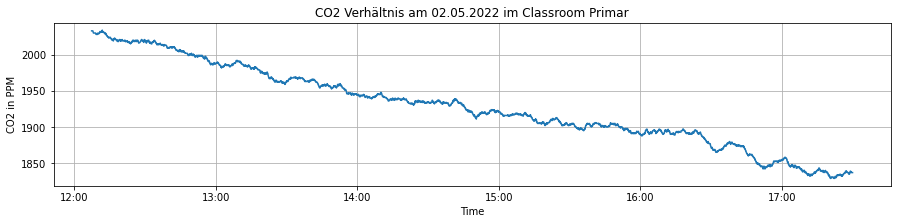

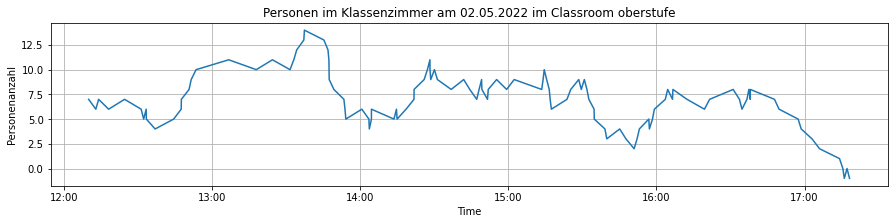

           id      id  fk_classroom_id             id          co2  \
count  3790.0  3790.0           3790.0    3790.000000  3789.000000   
mean      2.0     2.0              2.0  979106.054090  1928.174452   
std       0.0     0.0              0.0    3282.738828    54.063237   
min       2.0     2.0              2.0  973424.000000  1829.000000   
25%       2.0     2.0              2.0  976264.750000  1893.000000   
50%       2.0     2.0              2.0  979105.500000  1922.000000   
75%       2.0     2.0              2.0  981948.250000  1967.000000   
max       2.0     2.0              2.0  984791.000000  2034.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  3789.000000  3789.000000                     3790.0   3789.000000  
mean     24.415775    45.650491                        2.0  40329.045131  
std       0.604358     0.545692                        0.0     66.143147  
min      23.380000    44.660000                        2.0  40112.000

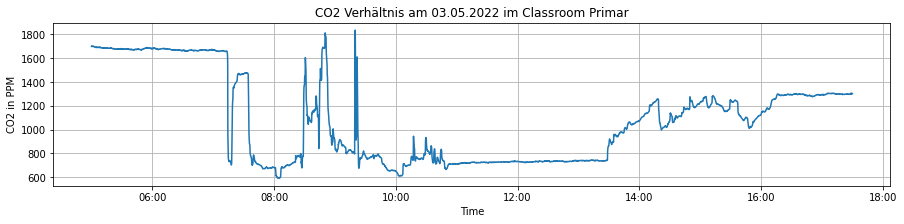

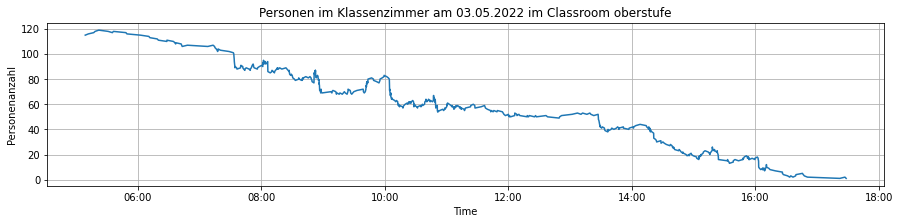

           id      id  fk_classroom_id            id          co2  \
count  8795.0  8795.0           8795.0  8.795000e+03  8788.000000   
mean      2.0     2.0              2.0  1.014279e+06  1086.413291   
std       0.0     0.0              0.0  7.110712e+03   360.547976   
min       2.0     2.0              2.0  1.003282e+06   591.000000   
25%       2.0     2.0              2.0  1.007682e+06   735.000000   
50%       2.0     2.0              2.0  1.013910e+06  1065.000000   
75%       2.0     2.0              2.0  1.020500e+06  1298.000000   
max       2.0     2.0              2.0  1.027095e+06  1836.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  8789.000000  8789.000000                     8795.0   8792.000000  
mean     23.443228    44.195764                        2.0  36013.732484  
std       2.498483     4.925492                        0.0  11658.953629  
min      15.520000    38.710000                        2.0    688.000000  
25%

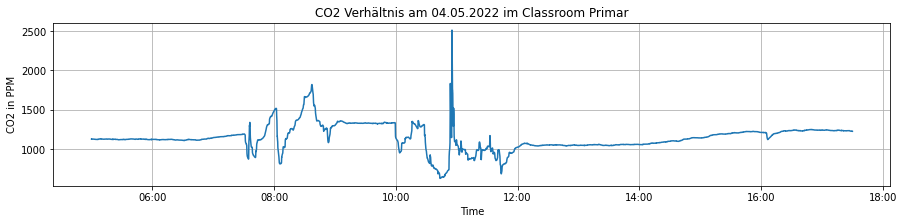

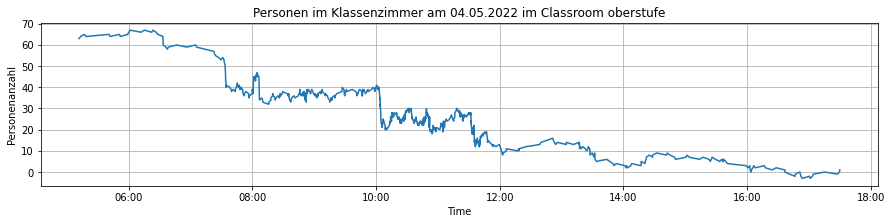

           id      id  fk_classroom_id            id          co2  \
count  8826.0  8826.0           8826.0  8.826000e+03  8818.000000   
mean      2.0     2.0              2.0  1.064711e+06  1143.597414   
std       0.0     0.0              0.0  7.649316e+03   156.977308   
min       2.0     2.0              2.0  1.051467e+06   628.000000   
25%       2.0     2.0              2.0  1.058088e+06  1057.000000   
50%       2.0     2.0              2.0  1.064712e+06  1127.000000   
75%       2.0     2.0              2.0  1.071335e+06  1233.000000   
max       2.0     2.0              2.0  1.077957e+06  2513.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  8820.000000  8819.000000                     8826.0   8817.000000  
mean     24.456984    44.253282                        2.0  35824.665986  
std       1.098643     1.470729                        0.0  12145.153038  
min      22.200000    41.260000                        2.0    880.000000  
25%

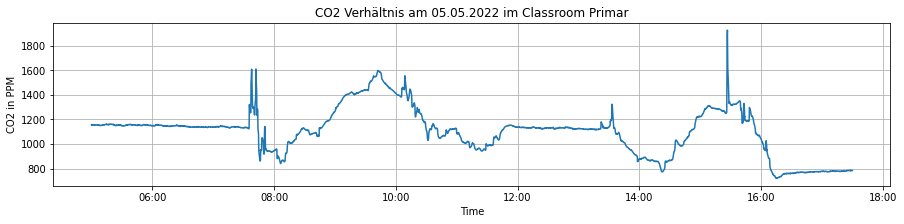

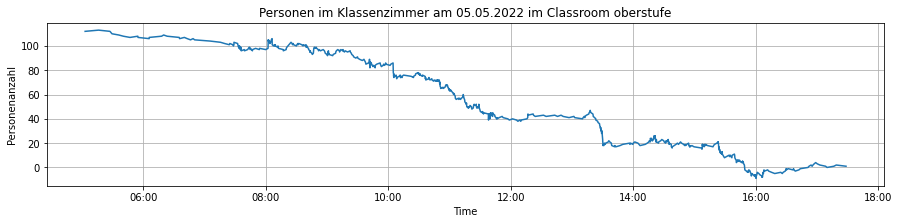

           id      id  fk_classroom_id            id          co2  \
count  8830.0  8830.0           8830.0  8.830000e+03  8825.000000   
mean      2.0     2.0              2.0  1.114245e+06  1102.520907   
std       0.0     0.0              0.0  7.649240e+03   186.942079   
min       2.0     2.0              2.0  1.101003e+06   720.000000   
25%       2.0     2.0              2.0  1.107621e+06   995.000000   
50%       2.0     2.0              2.0  1.114242e+06  1131.000000   
75%       2.0     2.0              2.0  1.120868e+06  1156.000000   
max       2.0     2.0              2.0  1.127496e+06  1925.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  8823.000000  8825.000000                     8830.0   8818.000000  
mean     23.731638    48.742916                        2.0  34449.876162  
std       0.716032     1.021649                        0.0  13281.770478  
min      22.090000    47.020000                        2.0    880.000000  
25%

In [196]:
## Week 1 Korrelation People to Co2

df_people = get_people_count_overtime(get_entrance('Primarklasse_EG', startDate = "2022-05-02 05:00:00", endDate = "2022-05-02 17:30:00"))
data = get_measurement(name = "Primarklasse_EG", startDate = "2022-05-02 05:00:00", endDate = "2022-05-02 17:30:00")



plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 02.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 02.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')


df_people = get_people_count_overtime(get_entrance('Primarklasse_EG', startDate = "2022-05-03 05:00:00", endDate = "2022-05-03 17:30:00"))
data = get_measurement(name = "Primarklasse_EG", startDate = "2022-05-03 05:00:00", endDate = "2022-05-03 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

df_people = get_people_count_overtime(get_entrance('Primarklasse_EG', startDate = "2022-05-04 05:00:00", endDate = "2022-05-04 17:30:00"))
data = get_measurement(name = "Primarklasse_EG", startDate = "2022-05-04 05:00:00", endDate = "2022-05-04 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 04.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 04.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

df_people = get_people_count_overtime(get_entrance('Primarklasse_EG', startDate = "2022-05-05 05:00:00", endDate = "2022-05-05 17:30:00"))
data = get_measurement(name = "Primarklasse_EG", startDate = "2022-05-05 05:00:00", endDate = "2022-05-05 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 05.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 05.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

#### Lässt sich aus den Messdaten der optimale Zeitpunkt zum Lüften (laufend) ermitteln?

--- Markdown ---

In [134]:
# psdeudo:
# Select time, max(co2) from Primarklasse_OG1 where time > '2020-05-03 08:00:00' and time < '2020-05-03 17:30:00'
# Select time, min(Co2) from Primarklasse_OG1 where in between (time_from 30 min before previous querry) and (time_to previous query)
Monday_05_02 = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-02 08:00:00", endDate = "2022-05-02 18:30:00")
Tuesday_05_03 = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 18:30:00")
Wendsday_05_04 = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-04 08:00:00", endDate = "2022-05-04 18:30:00")
Thursday_05_05 = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-05 08:00:00", endDate = "2022-05-05 18:30:00")
Firday_05_06 = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-06 08:00:00", endDate = "2022-05-06 18:30:00")

column = Monday_05_02["co2"]

print(Monday_05_02['co2'].max())

max_entry_m = Monday_05_02.query(f"co2 == {Monday_05_02['co2'].max()}")
max_entry_t = Tuesday_05_03.query(f"co2 == {Tuesday_05_03['co2'].max()}")
max_entry_w =Wendsday_05_04.query(f"co2 == {Wendsday_05_04['co2'].max()}")
max_entry_t =Thursday_05_05.query(f"co2 == {Thursday_05_05['co2'].max()}")
max_entry_f =Firday_05_06.query(f"co2 == {Firday_05_06['co2'].max()}")

print((max_entry_m['time'].values[0]))

Monday_05_02.query(f"time == '{pd.to_datetime(max_entry_m['time'].values[0])}'")

1011.0
2022-05-02T12:59:45.540150000


SyntaxError: invalid syntax (<unknown>, line 1)

#### Welche weiteren Erkenntnisse lassen sich aus den erfassten Messdaten ableiten?

--- Markdown ---

In [27]:
# Strom sparen, wie kann möglichst viel Co2 eingesparrt werden, jedoch möglichst wenig Tempatur gesenkt werden
con = get_connection()
sql_stations = f"""
    SELECT * from smartclassroom_dev.public.api_measurement where name = 'Primarklasse_OG1'
"""    
pd.read_sql_query(sql_stations, con)


DatabaseError: Execution failed on sql '
    SELECT * from smartclassroom_dev.public.api_measurement where name = 'Primarklasse_OG1'
': column "name" does not exist
LINE 2: ...m smartclassroom_dev.public.api_measurement where name = 'Pr...
                                                             ^
HINT:  Perhaps you meant to reference the column "api_measurement.time".


#### Welche Erkenntnisse von Dritten können Sie allenfalls bestätigen/widerlegen?

--- Markdown ---